In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [212]:
df = pd.read_csv('/Users/anikatripathi/Downloads/data/student/student-mat.csv', sep=';')
print(df.head())
# had to seperate by ; instead of the default , bc that is standard practice is european countries

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]


In [214]:
# Data Cleaning and preprocessing

# Drop G1 and G2
df = df.drop(columns=['G1', 'G2'])

# Binary Encoding 
binary_columns = ['sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup',
                  'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

for col in binary_columns:
    df[col] = df[col].map({'yes': 1, 'no': 0, 'F': 0, 'M': 1, 'U': 1, 'R': 0, 'LE3': 0, 'GT3': 1, 'T': 1, 'A': 0})

# One-Hot Encoding 
df = pd.get_dummies(df, columns=['school', 'Mjob', 'Fjob', 'reason', 'guardian'], drop_first=True)

# Convert G3 to letter grades
def convert_to_letter_grade(g):
    if g >= 15:
        return 'A'
    elif g >= 13:
        return 'B'
    elif g >= 10:
        return 'C'
    elif g >= 8:
        return 'D'
    else:
        return 'F'

y_letter = df['G3'].apply(convert_to_letter_grade)
X = df.drop(columns=['G3'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_letter, test_size=0.2, random_state=75)

print(df.head())

   sex  age  address  famsize  Pstatus  Medu  Fedu  traveltime  studytime  \
0    0   18        1        1        0     4     4           2          2   
1    0   17        1        1        1     1     1           1          2   
2    0   15        1        0        1     1     1           1          2   
3    0   15        1        1        1     4     2           1          3   
4    0   16        1        1        1     3     3           1          2   

   failures  ...  Mjob_teacher  Fjob_health  Fjob_other  Fjob_services  \
0         0  ...         False        False       False          False   
1         0  ...         False        False        True          False   
2         3  ...         False        False        True          False   
3         0  ...         False        False       False           True   
4         0  ...         False        False        True          False   

   Fjob_teacher  reason_home  reason_other  reason_reputation  \
0          True        Fals

In [216]:
num_rows = len(df)
print("Number of rows:", num_rows)

Number of rows: 395


In [218]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [220]:
print(y_letter.value_counts().reindex(['A', 'B', 'C', 'D', 'F']))

G3
A     73
B     58
C    134
D     60
F     70
Name: count, dtype: int64


In [222]:
# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_balanced, y_train_balanced)
y_pred = knn.predict(X_test_scaled)

In [224]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.569620253164557


In [226]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 Score (Macro):", f1)

F1 Score (Macro): 0.5825598814994362


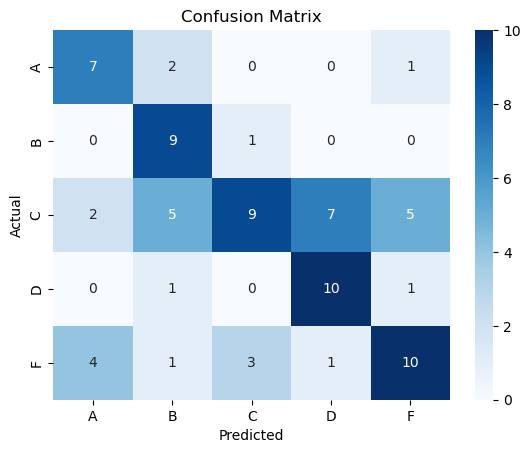

In [228]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A','B','C','D','F'], yticklabels=['A','B','C','D','F'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [230]:
print("Total test samples:", len(y_test))

Total test samples: 79


In [234]:
import warnings
warnings.filterwarnings('ignore')

In [236]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 21)),  # Try k from 1 to 20
    'weights': ['uniform', 'distance'],  # Equal weight or distance-weighted
    'metric': ['euclidean', 'manhattan']  # Try different distance metrics
}

# Initialize KNN (no need to set any params yet)
knn = KNeighborsClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # You can also try 'f1_macro'
    n_jobs=-1  # Use all CPU cores for speed
)

# Fit grid search on training data
grid_search.fit(X_train_scaled, y_train)

# Best model
best_knn = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on test set
y_pred = best_knn.predict(X_test_scaled)
from sklearn.metrics import accuracy_score
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.31939484126984125
Test Set Accuracy: 0.43037974683544306


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

In [238]:
best_knn = KNeighborsClassifier(
    n_neighbors=19,
    weights='distance',
    metric='manhattan')


best_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=19, weights='distance')

In [240]:
y_pred = best_knn.predict(X_test_scaled)

In [242]:
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.43037974683544306


In [244]:
print("F1 Score (Macro):", f1_score(y_test, y_pred, average='macro'))

F1 Score (Macro): 0.30254389190182923


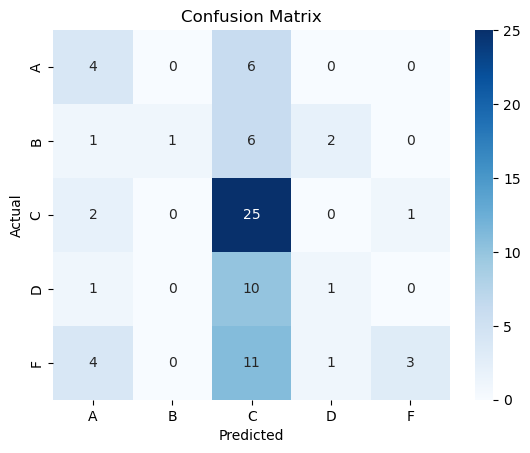

In [246]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'B', 'C', 'D', 'F'], yticklabels=['A', 'B', 'C', 'D', 'F'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()